# Модель лесного пожара

Лес состоит и пустой сетки $N \times N$. На протяжении каждого периода случайным образом
выбирается участок на сетке. Если участок пустой, то с вероятностью $p$ на нем вырастает
дерево, а с веростностью $1 - p$ не происходит ничего.

Если на участке растет дерево, то оно
с вероятностью $1 - p$ загорается и огонь распроcтраняется на все примыкающие участки с
деревьями.


In [219]:
import matplotlib.pyplot as plt
import numpy as np

In [220]:
class ForestField:
    def __init__(self, n=5, p = 0.6) -> None:
        self.n = n
        self.field = np.zeros((self.n, self.n), dtype=np.int32)
        self.p = p
        self.treesPreFire = []
        self.treesPostFire = []
        self.dirt = 0
        self.tree = 1
        self.fire = -1
         
    def step(self, burnAll = False):
        cell = (np.random.randint(0, self.n), np.random.randint(0, self.n))
        rand_val = np.random.rand()
        #forest growth
        if self.field[cell[0], cell[1]] == self.dirt and rand_val < self.p:
                self.field[cell[0], cell[1]] = self.tree
        self.treesPreFire.append(self.countTrees())
        #lightning strike
        if self.field[cell[0], cell[1]] == self.tree and rand_val >= self.p:
            self.field[cell[0], cell[1]] = self.fire
        #fire spread
        self.fireSpread(burnAll)
        #fire extinguish
        self.field[self.field == self.fire] = self.dirt
        self.treesPostFire.append(self.countTrees())
        
    def fireSpread(self, burnAll = False):
        dx = [-1, 0, 1, 0, -1, -1, 1, 1]
        dy = [0, 1, 0, -1, -1, 1, 1, -1]
        old_field = None
        while old_field is None or (old_field != self.field).any():
            old_field = self.field.copy()
            fire_indices = np.where(self.field == self.fire)
            fire_indices = list(zip(fire_indices[0], fire_indices[1]))
            for idx in fire_indices:
                i, j = idx
                for k in range(len(dx)):
                    if not ( 0 <= i + dx[k] < self.n and 0 <= j + dy[k] < self.n):
                        continue
                    if self.field[i + dx[k]][j + dy[k]] == self.dirt:
                        continue
                    self.field[i + dx[k]][j + dy[k]] = self.fire
            if not burnAll:
                return
        
    def countTrees(self):
        return np.sum(self.field[self.field == self.tree])

Посмотрим на численность леса в течение продолжительного времени и исследуем распределение леса по его размеру

In [221]:
n = 100
p = 0.7
forest = ForestField(n=n, p=p)
time_steps = 30000

In [222]:
for _ in range(time_steps):
    forest.step(burnAll=True)

Text(0, 0.5, 'Размер леса')

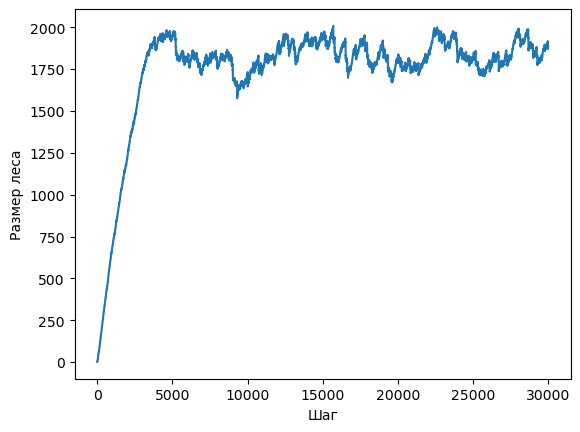

In [228]:
plt.plot(np.arange(len(forest.treesPreFire)), forest.treesPreFire)
plt.xlabel('Шаг')
plt.ylabel('Размер леса')

Для $p=0.7$ можно видеть, большую часть времени лес растёт равномерно с одинаковой скоростью. Иногда случаются пожары и размер леса резко уменьшается.

Ближе ко второй половине периода эксперимента и далее размеры леса выходят на определённый уровень, около которого колебаются размеры леса. Исследуем, как зависит средний уровень леса от вероятности $p$

In [225]:
p_vals = np.arange(0.01, 1, 0.09)
mean_vals = []
for p in p_vals:
    exp_forest = ForestField(n,p)
    for _ in range(time_steps):
        exp_forest.step(burnAll=True)
    mean_vals.append(np.mean(exp_forest.treesPostFire[int(time_steps / 2):]))

In [242]:
def calc_determination(data_x, data_y, coeffs):
    approx_y = np.polyval(coeffs, data_x)
    y_dev = np.sum((data_y - np.mean(data_y))**2)
    approx_dev = np.sum((approx_y - data_y)**2)
    return np.round(1 - approx_dev / y_dev, 2)

def approx_data(data_x, data_y, deg = 1):
    coeffs = np.polyfit(data_x, data_y, deg)
    determination = calc_determination(data_x, data_y, coeffs)
    return coeffs, determination

In [243]:
coeffs, r = approx_data(p_vals, mean_vals)
p_ax = np.linspace(0,1)
a_fit = np.polyval(coeffs, p_ax)

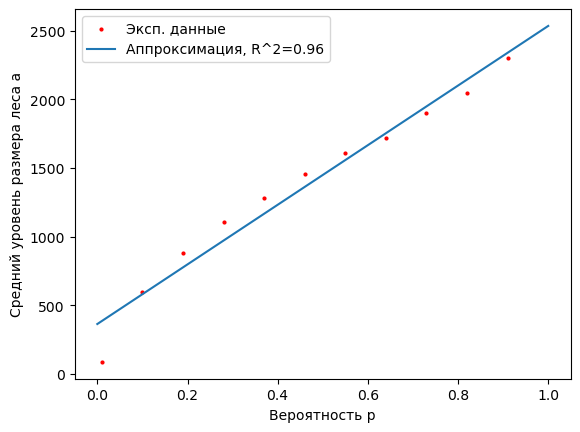

In [244]:
plt.scatter(p_vals, mean_vals, s=4, label='Эксп. данные', color='red')
plt.plot(p_ax, a_fit, label=f'Аппроксимация, R^2={r}')
plt.xlabel("Вероятность p")
plt.ylabel("Средний уровень размера леса a")
plt.legend()